# CSC 215 ARTIFICAL INTELLIGENCE - FINAL PROJECT
## Analysis of Machine Learning algorithms for detecting fraud credit card transactions.
###  Team Members: Advait Kunte, Devika Manohar


# Import libraries and helper functions

In [29]:
import seaborn as sns
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs

import csv
import numpy as np
%matplotlib inline

import cv2
import glob
from IPython.display import Image
from google.colab import drive
from numpy import percentile

from tensorflow.keras import optimizers
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D,\
                                    concatenate, Dropout, BatchNormalization, LSTM,\
                                    Conv1D, MaxPooling1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import plot_model, to_categorical

from sklearn import metrics, preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier


from collections.abc import Sequence

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


class AI_Helper:
    def __init__(self):
        pass
    
    # Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
    def encode_text_dummy(self, df, name):
        dummies = pd.get_dummies(df[name])
        for x in dummies.columns:
            dummy_name = "{}-{}".format(name, x)
            df[dummy_name] = dummies[x]
        df.drop(name, axis=1, inplace=True)



    # Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
    def encode_text_index(self, df, name):
        le = preprocessing.LabelEncoder()
        df[name] = le.fit_transform(df[name])
        return le.classes_


    # Encode a numeric column as zscores
    def encode_numeric_zscore(self, df, name, mean=None, sd=None):
        if mean is None:
            mean = df[name].mean()

        if sd is None:
            sd = df[name].std()

        df[name] = (df[name] - mean) / sd


    # Convert all missing values in the specified column to the median
    def missing_median(self, df, name):
        med = df[name].median()
        df[name] = df[name].fillna(med)


    # Convert all missing values in the specified column to the default
    def missing_default(self, df, name, default_value):
        df[name] = df[name].fillna(default_value)


    # Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
    def to_xy(self, df, target):
        result = []
        for x in df.columns:
            if x != target:
                result.append(x)
        # find out the type of the target column. 
        target_type = df[target].dtypes
        target_type = target_type[0] if isinstance(target_type, Sequence) else target_type
        # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
        if target_type in (np.int64, np.int32):
            # Classification
            print('Classification')
            dummies = pd.get_dummies(df[target])
            return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
        else:
            # Regression
            print('Regression')
            return df[result].values.astype(np.float32), df[target].values.astype(np.float32)

    # Nicely formatted time string
    def hms_string(self, sec_elapsed):
        h = int(sec_elapsed / (60 * 60))
        m = int((sec_elapsed % (60 * 60)) / 60)
        s = sec_elapsed % 60
        return "{}:{:>02}:{:>05.2f}".format(h, m, s)


    # Regression chart.
    def chart_regression(self, pred,y,sort=True):
        t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
        if sort:
            t.sort_values(by=['y'],inplace=True)
        a = plt.plot(t['y'].tolist(),label='expected')
        b = plt.plot(t['pred'].tolist(),label='prediction')
        plt.ylabel('output')
        plt.legend()
        plt.show()

    # Remove all rows where the specified column is +/- sd standard deviations
    def remove_outliers(self, df, name, sd):
        drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
        df.drop(drop_rows, axis=0, inplace=True)


    # Encode a column to a range between normalized_low and normalized_high.
    def encode_numeric_range(self, df, name, normalized_low=-1, normalized_high=1,
                             data_low=None, data_high=None):
        if data_low is None:
            data_low = min(df[name])
            data_high = max(df[name])

        df[name] = ((df[name] - data_low) / (data_high - data_low)) \
                   * (normalized_high - normalized_low) + normalized_low

    def list_diff(self, list1, list2):
        return (list(list(set(list1)-set(list2)) + list(set(list2)-set(list1)))) 


    # Plot a confusion matrix.
    # cm is the confusion matrix, names are the names of the classes.
    def __plot_confusion_matrix(self, cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
        plt.figure()
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(names))
        plt.xticks(tick_marks, names, rotation=45)
        plt.yticks(tick_marks, names)
        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.show()

    def plot_cm(self, y_test_values, pred, classes):
        cm = confusion_matrix(y_test_values, pred)
        print(cm)
        print('Plotting confusion matrix')
        plt.figure()
        self.__plot_confusion_matrix(cm, classes)
        plt.show()

    # Plot an ROC. pred - the predictions, y - the expected output.
    def plot_roc(self, pred,y):
        fpr, tpr, thresholds = roc_curve(y, pred)
        roc_auc = auc(fpr, tpr)

        plt.figure()
        plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC)')
        plt.legend(loc="lower right")
        plt.show()

    def to_sequences(self, seq_size, data):
        x = []
        y = []

        for i in range(len(data)-seq_size-1):
            #print(i)
            window = data[i:(i+seq_size)]
            after_window = data[i+seq_size]
            window = [[x] for x in window]
            #print("{} - {}".format(window,after_window))
            x.append(window)
            y.append(after_window)
            
        return np.array(x),np.array(y)

    def to_sequences_nn(self, data, y_data, SEQUENCE_SIZE):
        x = []
        y = []

        for i in range(len(data)-SEQUENCE_SIZE-1):
            #print(i)
            window = data[i:(i+SEQUENCE_SIZE)]
            after_window = y_data[i+SEQUENCE_SIZE]
            #window = [[x] for x in window]
            #print("{} - {}".format(window,after_window))
            x.append(window)
            y.append(after_window)

        return np.array(x),np.array(y)

    def print_metrics(self, df_test_y, pred):
        # accuracy metrics for knn regression model
        accuracy_knn = metrics.accuracy_score(df_test_y, pred)
        print("Accuracy score: {}".format(accuracy_knn))
        # precision metrics for knn model
        precision_knn = metrics.precision_score(df_test_y, pred, 
                                                average= "weighted")
        print("Precision score: {}".format(precision_knn))
        # recall metrics for knn model
        recall_knn = metrics.recall_score(df_test_y, pred, 
                                        average= "weighted")
        print("Recall score: {}".format(recall_knn))
        # F1 metrics for knn model
        f1_knn = metrics.f1_score(df_test_y, pred, 
                                average= "weighted")
        print("F1 score: {}".format(f1_knn))
        # generate the classification report for knn model
        print(classification_report(df_test_y,pred))

ai_helper = AI_Helper()


# Load dataset

In [30]:
drive.mount('/content/drive')
dataset_path = "/content/drive/My Drive/Colab Notebooks/"
filename_read = os.path.join(dataset_path, "creditcard_data/creditcard_csv.csv")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data pre-processing
- Rename Class to Fraud
- Remove quotes(') from the data
- Show NA values
- Plot bar graph for Fruad and Genuine transactions

NA Values
Empty DataFrame
Columns: [Time, V1, V2, V3, V4, V5, V6, V7, V8, V9, V10, V11, V12, V13, V14, V15, V16, V17, V18, V19, V20, V21, V22, V23, V24, V25, V26, V27, V28, Amount, Fraud]
Index: []


(284807, 31)

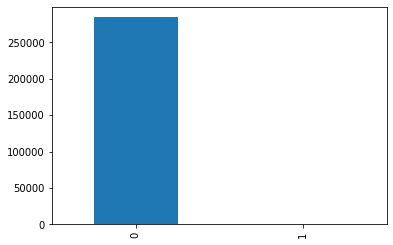

In [31]:
df = pd.read_csv(filename_read , na_values=['NA', '?', None, 'None', '-'])
df = df.rename(columns={'Class': 'Fraud'})
df['Fraud'] = df['Fraud'].map({"'0'":0, "'1'":1})
print("NA Values\n{}".format( df[df.isna().any(axis=1)] ))
df['Fraud'].value_counts().plot(kind='bar')
df.shape

#Remove outliers for the amount feature

Max fraud value = [2125.87]
(284518, 31)


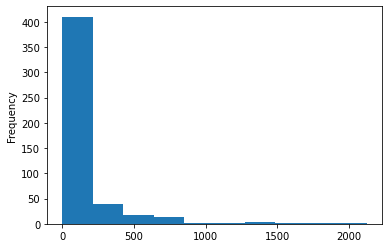

In [32]:
df[(df.Fraud==1)].Amount.plot(kind='hist')
print("Max fraud value = {}".format(
    df[(df.Fraud==1)].Amount.sort_values()[-1:].values))
# Removing the rows whose amount < 3000
df = df[df.Amount < 3000]
print(df.shape)

#Normalise other features : Time and Amount

In [33]:
ai_helper.encode_numeric_zscore(df, ['Amount','Time'])
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Fraud
0,-1.996555,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0.339208,0
1,-1.996555,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,-0.419081,0
2,-1.996534,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,1.521258,0
3,-1.996534,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0.204406,0
4,-1.996513,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,-0.071753,0


# Split data in 70/30 ratio for train and test and split data into X and Y


In [34]:
df_train, df_test = train_test_split(df, test_size=0.30, random_state=42)
y_train = df_train['Fraud']
x_train = df_train.drop(columns=['Fraud'], axis=1)
y_test = df_test['Fraud']
x_test = df_test.drop(columns=['Fraud'], axis=1)
print("Shape of x_train: {}\nShape of y_train: {}\
\nShape of x_test: {}\nShape of y_test: {}"\
    .format(x_train.shape, y_train.shape, x_test.shape, y_test.shape))

Shape of x_train: (199162, 30)
Shape of y_train: (199162,)
Shape of x_test: (85356, 30)
Shape of y_test: (85356,)


# Balancing the data
- Create Under sampled dataset
- Create Under sampled and Over sampled hybrid dataset


### Under sample

(688, 30) (688,)


(688, 30)

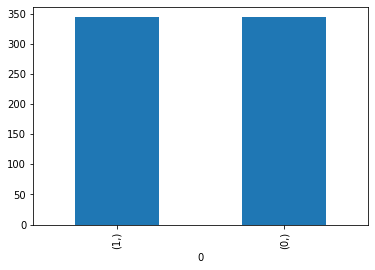

In [35]:
undersample = RandomUnderSampler(sampling_strategy='majority')
x_train_under, y_train_under = undersample.fit_resample(x_train, y_train)
print(x_train_under.shape, y_train_under.shape)
df_pd= pd.DataFrame(y_train_under)
pd.DataFrame(y_train_under).value_counts().plot(kind='bar')
df_x_train_under = pd.DataFrame(x_train_under, columns=x_train.columns)
df_x_train_under.shape

###Oversampled

(397636, 30) (397636,)


(397636, 30)

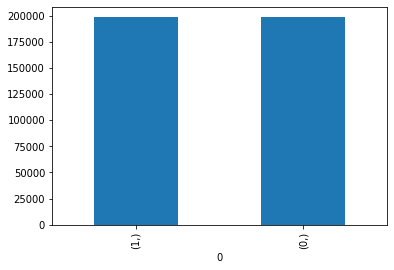

In [36]:
oversample = RandomOverSampler(sampling_strategy='minority')
x_train_over, y_train_over = oversample.fit_resample(x_train, y_train)
print(x_train_over.shape, y_train_over.shape)
df_pd= pd.DataFrame(y_train_over)
pd.DataFrame(y_train_over).value_counts().plot(kind='bar')
df_x_train_over = pd.DataFrame(x_train_over, columns=x_train.columns)
df_x_train_over.shape

### Hybrid (Under and Over Sample)

(172306, 30) (172306,)


(172306, 30)

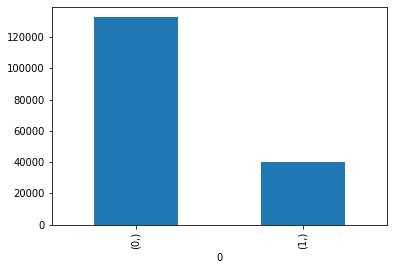

In [37]:
oversample = RandomOverSampler(sampling_strategy=0.2)
x_train_hybrid, y_train_hybrid = oversample.fit_resample(x_train, y_train)
undersample = RandomUnderSampler(sampling_strategy=0.3)
x_train_hybrid, y_train_hybrid = undersample.fit_resample(x_train_hybrid, y_train_hybrid)
print(x_train_hybrid.shape, y_train_hybrid.shape)
pd.DataFrame(y_train_hybrid).value_counts().plot(kind='bar')
df_x_train_hybrid = pd.DataFrame(x_train_hybrid, columns=x_train.columns)
df_x_train_hybrid.shape

# Features Analysis
- RandomForestClassification using SelectFromModel library
- Corelation matrix
- Distribution plot and boxplot of features


### SelectFromModel feature selection - This helps us understand the features not to drop

In [38]:
# configure to select a subset of features
fs = SelectFromModel(RandomForestClassifier(n_estimators=200), max_features=20)
# learn relationship from training data
fs.fit(x_train_hybrid, y_train_hybrid)
# transform train input data
x_train_hybrid_fs = fs.transform(x_train_hybrid)

feature_idx = fs.get_support()
x_train_columns = df_train.columns.drop('Fraud')
feature_name = x_train_columns[feature_idx]
print("Important features: {}".format(feature_name.values))

Important features: ['V3' 'V4' 'V7' 'V10' 'V11' 'V12' 'V14' 'V16' 'V17']


### Correlation Matrix 

####Correlation Matrix for unbalanced data set

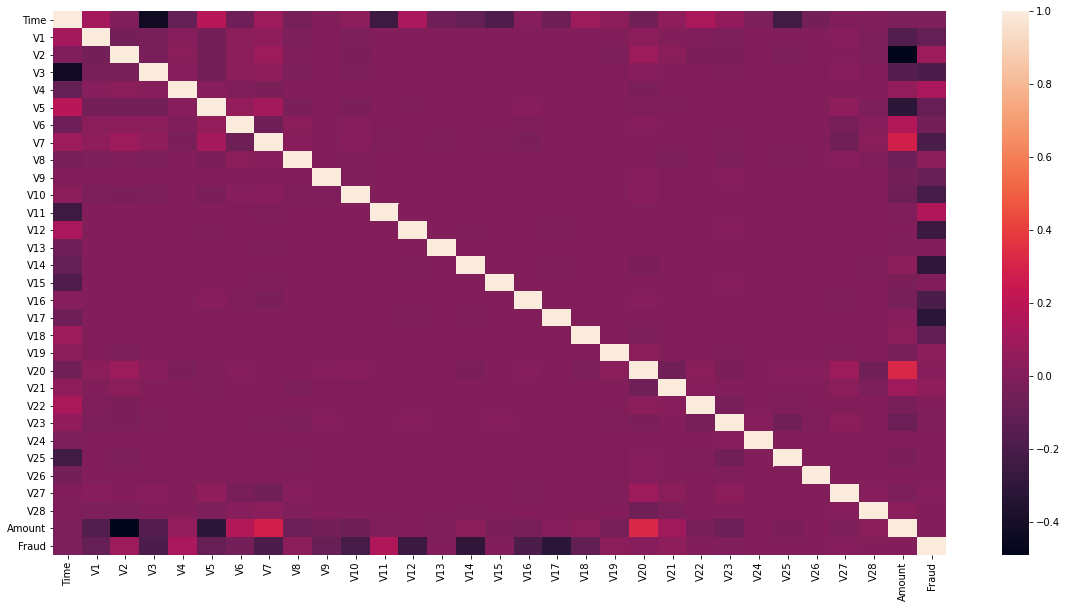

In [39]:
fig, ax = plt.subplots(figsize=(20,10)) 
corr = df_train.corr()
sns.heatmap(corr, annot_kws={'size':20})
plt.show()

#### Correlation Matrix for undersampled dataset




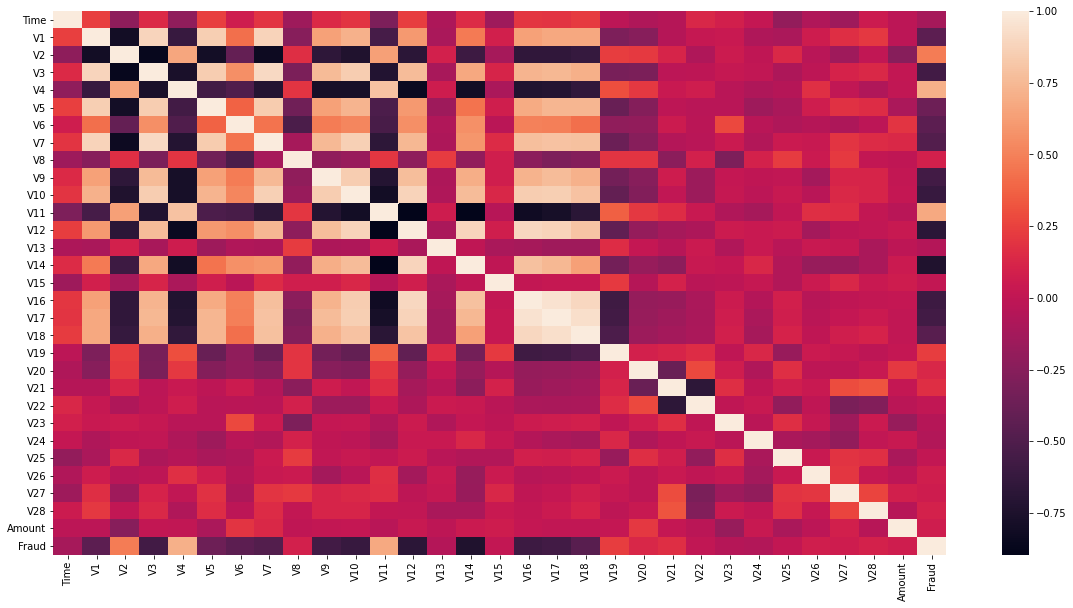

In [40]:
df_under_merged = df_x_train_under.copy()
df_under_merged['Fraud'] = pd.DataFrame(y_train_under)

fig, ax = plt.subplots(figsize=(20,10)) 
corr_under = df_under_merged.corr()
sns.heatmap(corr_under, annot_kws={'size':20})
plt.show()

In [41]:
corr= df_under_merged.corr()
corr_y = corr["Fraud"]
highest_corr = corr_y[corr_y <-0.5]
highest_corr.sort_values(ascending=True)

V14   -0.739739
V12   -0.675280
V10   -0.615688
V16   -0.590282
V9    -0.566839
V17   -0.564771
V3    -0.563031
Name: Fraud, dtype: float64

#### Correlation Matrix for oversampled dataset




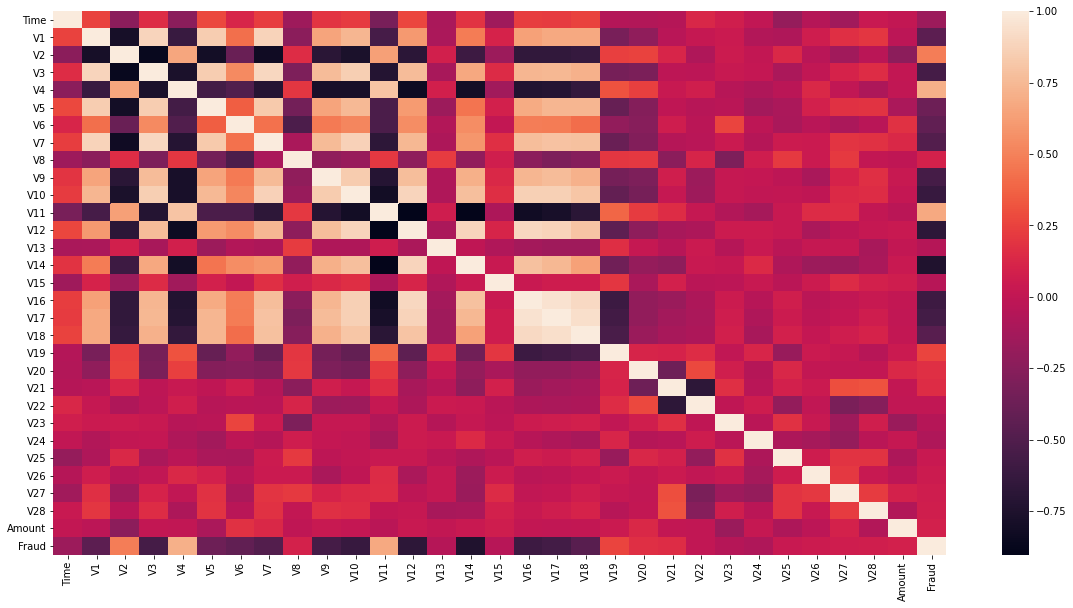

In [42]:
df_over_merged = df_x_train_over.copy()
df_over_merged['Fraud'] = pd.DataFrame(y_train_over)

fig, ax = plt.subplots(figsize=(20,10)) 
corr_over = df_over_merged.corr()
sns.heatmap(corr_over, annot_kws={'size':20})
plt.show()

In [43]:
corr= df_over_merged.corr()
corr_y = corr["Fraud"]
highest_corr = corr_y[corr_y <-0.5]
highest_corr.sort_values(ascending=True)

V14   -0.743933
V12   -0.677769
V10   -0.620929
V16   -0.596816
V17   -0.560766
V3    -0.557052
V9    -0.554047
Name: Fraud, dtype: float64

#### Correlation Matrix for hyrbid dataset

---



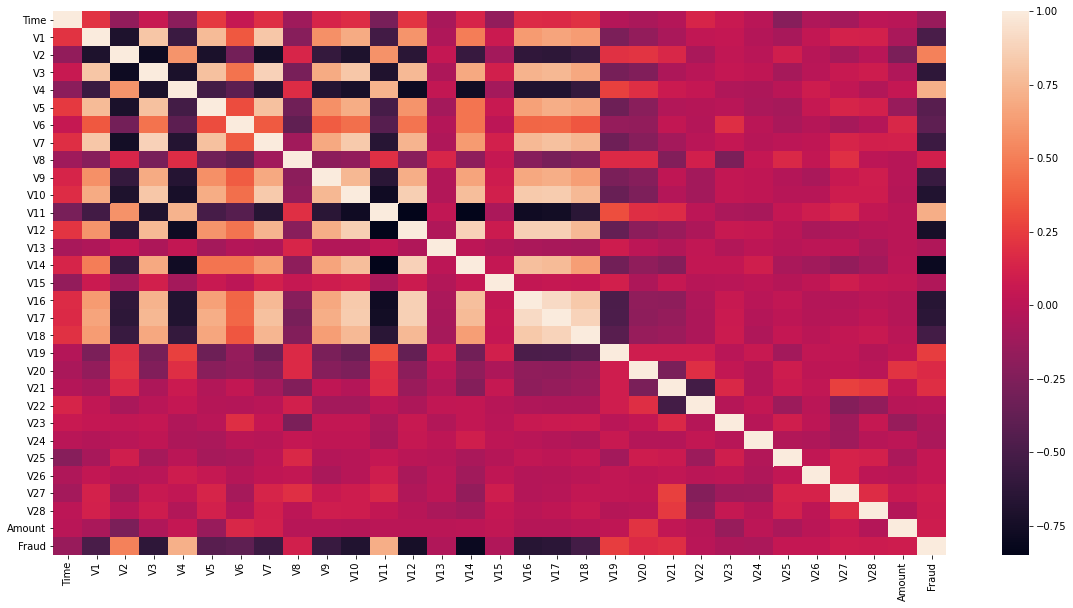

In [44]:
df_hybrid_merged = df_x_train_hybrid.copy()
df_hybrid_merged['Fraud'] = y_train_hybrid

fig, ax = plt.subplots(figsize=(20,10)) 
corr_hybrid = df_hybrid_merged.corr()
sns.heatmap(corr_hybrid, annot_kws={'size':20})
plt.show()

#### Identifying Features with negative correlation

In [45]:
corr= df_hybrid_merged.corr()
corr_y = corr["Fraud"]
highest_corr = corr_y[corr_y < -0.5]
highest_corr.sort_values(ascending=True)

V14   -0.796418
V12   -0.739517
V10   -0.684502
V16   -0.658963
V17   -0.638660
V3    -0.622745
V9    -0.571076
V7    -0.558130
V18   -0.519336
Name: Fraud, dtype: float64

#### Identifying Features with positive correlation

In [46]:
corr= df_hybrid_merged.corr()
corr_y = corr["Fraud"]
highest_corr = corr_y[corr_y > 0.5]
highest_corr.sort_values(ascending=True)

V2       0.515840
V11      0.710388
V4       0.716315
Fraud    1.000000
Name: Fraud, dtype: float64

#Box plot analysis and identifying outliers

Text(0.5, 1.0, 'V17 vs Class Negative \n Correlation')

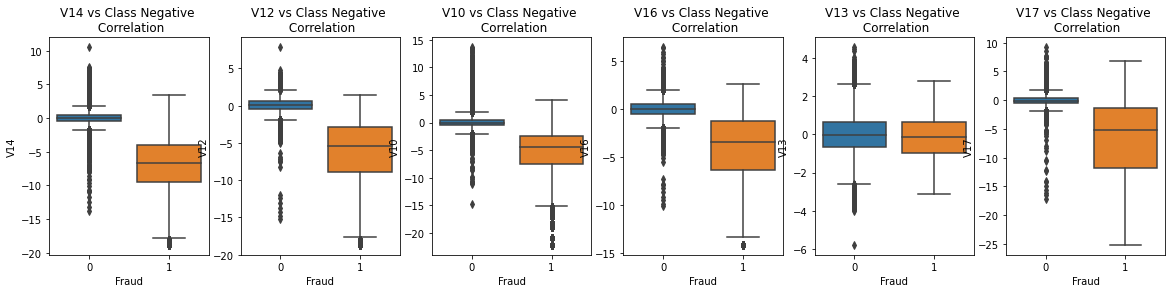

In [47]:
f, axes = plt.subplots(ncols=6, figsize=(20,4))

sns.boxplot(x="Fraud", y="V14", data=df_hybrid_merged, ax=axes[0])
axes[0].set_title('V14 vs Class Negative \n Correlation')

sns.boxplot(x="Fraud", y="V12", data=df_hybrid_merged, ax=axes[1])
axes[1].set_title('V12 vs Class Negative \n Correlation')

sns.boxplot(x="Fraud", y="V10", data=df_hybrid_merged, ax=axes[2])
axes[2].set_title('V10 vs Class Negative \n Correlation')

sns.boxplot(x="Fraud", y="V16", data=df_hybrid_merged, ax=axes[3])
axes[3].set_title('V16 vs Class Negative \n Correlation')

sns.boxplot(x="Fraud", y="V13", data=df_hybrid_merged, ax=axes[4])
axes[4].set_title('V13 vs Class Negative \n Correlation')

sns.boxplot(x="Fraud", y="V17", data=df_hybrid_merged, ax=axes[5])
axes[5].set_title('V17 vs Class Negative \n Correlation')

#Removing the outliners for the high negative Correlated features using Interquartile Range Method


### For V14 feature

In [48]:
v14_fraud = df_hybrid_merged['V14'].loc[df_hybrid_merged['Fraud'] == 1].values
q25, q75 = percentile(v14_fraud, 25), percentile(v14_fraud, 75)
iqr = q75 - q25
print('Percentiles: 25th=%.3f, 75th=%.3f, IQR=%.3f' % (q25, q75, iqr))

# calculate the outlier cutoff
cut_off_v14 = iqr * 1.5
lower_v14, upper_v14 = q25 - cut_off_v14, q75 + cut_off_v14

# identify outliers
outliers = [x for x in v14_fraud if x < lower_v14 or x > upper_v14]
print('Feature V14 Outliers for Fraud Cases: {}'.format(len(outliers)))

df_hybrid_merged.shape

Percentiles: 25th=-9.505, 75th=-3.926, IQR=5.579
Feature V14 Outliers for Fraud Cases: 252


(172306, 31)

In [49]:
#dropping the outliers for v14 feature
df_hybrid_merged = df_hybrid_merged.drop(df_hybrid_merged[(df_hybrid_merged['V14'] > upper_v14) 
    | (df_hybrid_merged['V14'] < lower_v14)].loc[df_hybrid_merged['Fraud'] == 1].index)
df_hybrid_merged.shape

(172054, 31)

### For V12 feature

In [50]:
v12_fraud = df_hybrid_merged['V12'].loc[df_hybrid_merged['Fraud'] == 1].values
q25, q75 = percentile(v12_fraud, 25), percentile(v12_fraud, 75)
iqr = q75 - q25
print('Percentiles: 25th=%.3f, 75th=%.3f, IQR=%.3f' % (q25, q75, iqr))

# calculate the outlier cutoff
cut_off_v12 = iqr * 1.5
lower_v12, upper_v12 = q25 - cut_off_v12, q75 + cut_off_v12

# identify outliers
outliers = [x for x in v12_fraud if x < lower_v12 or x > upper_v12]
print('Feature V12 Outliers for Fraud Cases: {}'.format(len(outliers)))

df_hybrid_merged.shape

Percentiles: 25th=-8.762, 75th=-2.820, IQR=5.942
Feature V12 Outliers for Fraud Cases: 332


(172054, 31)

In [51]:
#dropping the outliers for v12 feature
df_hybrid_merged = df_hybrid_merged.drop(df_hybrid_merged[(df_hybrid_merged['V12'] > upper_v12) 
    | (df_hybrid_merged['V12'] < lower_v12)].loc[df_hybrid_merged['Fraud'] == 1].index)
df_hybrid_merged.shape

(171722, 31)

###For V10 feature

In [52]:
v10_fraud = df_hybrid_merged['V10'].loc[df_hybrid_merged['Fraud'] == 1].values
q25, q75 = percentile(v10_fraud, 25), percentile(v10_fraud, 75)
iqr = q75 - q25
print('Percentiles: 25th=%.3f, 75th=%.3f, IQR=%.3f' % (q25, q75, iqr))

# calculate the outlier cutoff
cut_off_v10 = iqr * 1.5
lower_v10, upper_v10 = q25 - cut_off_v10, q75 + cut_off_v10

# identify outliers
outliers = [x for x in v10_fraud if x < lower_v10 or x > upper_v10]
print('Feature V10 Outliers for Fraud Cases: {}'.format(len(outliers)))

df_hybrid_merged.shape

Percentiles: 25th=-7.455, 75th=-2.411, IQR=5.044
Feature V10 Outliers for Fraud Cases: 1916


(171722, 31)

In [53]:
#dropping the outliers for v10 feature
df_hybrid_merged = df_hybrid_merged.drop(df_hybrid_merged[(df_hybrid_merged['V10'] > upper_v10) 
    | (df_hybrid_merged['V10'] < lower_v10)].loc[df_hybrid_merged['Fraud'] == 1].index)
df_hybrid_merged.shape

(169806, 31)

#Box plot analysis after removing outliers

Text(0.5, 1.0, 'V10 vs Class Negative \n Correlation')

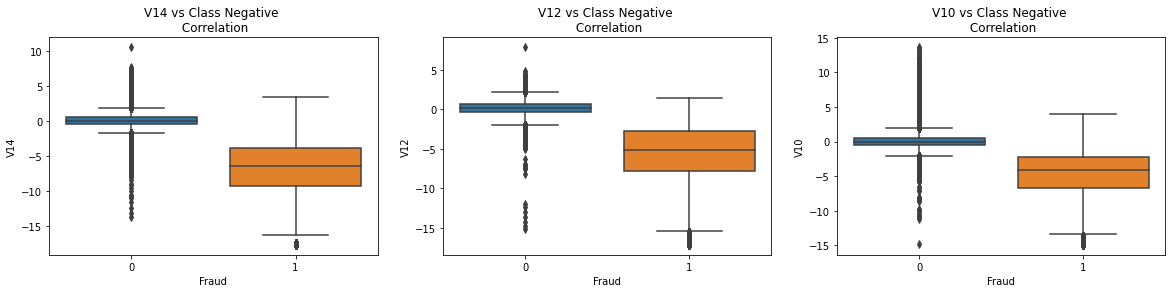

In [54]:
f, axes = plt.subplots(ncols=3, figsize=(20,4))

sns.boxplot(x="Fraud", y="V14", data=df_hybrid_merged, ax=axes[0])
axes[0].set_title('V14 vs Class Negative \n Correlation')

sns.boxplot(x="Fraud", y="V12", data=df_hybrid_merged, ax=axes[1])
axes[1].set_title('V12 vs Class Negative \n Correlation')

sns.boxplot(x="Fraud", y="V10", data=df_hybrid_merged, ax=axes[2])
axes[2].set_title('V10 vs Class Negative \n Correlation')

# Distribution plot & remove non useful features

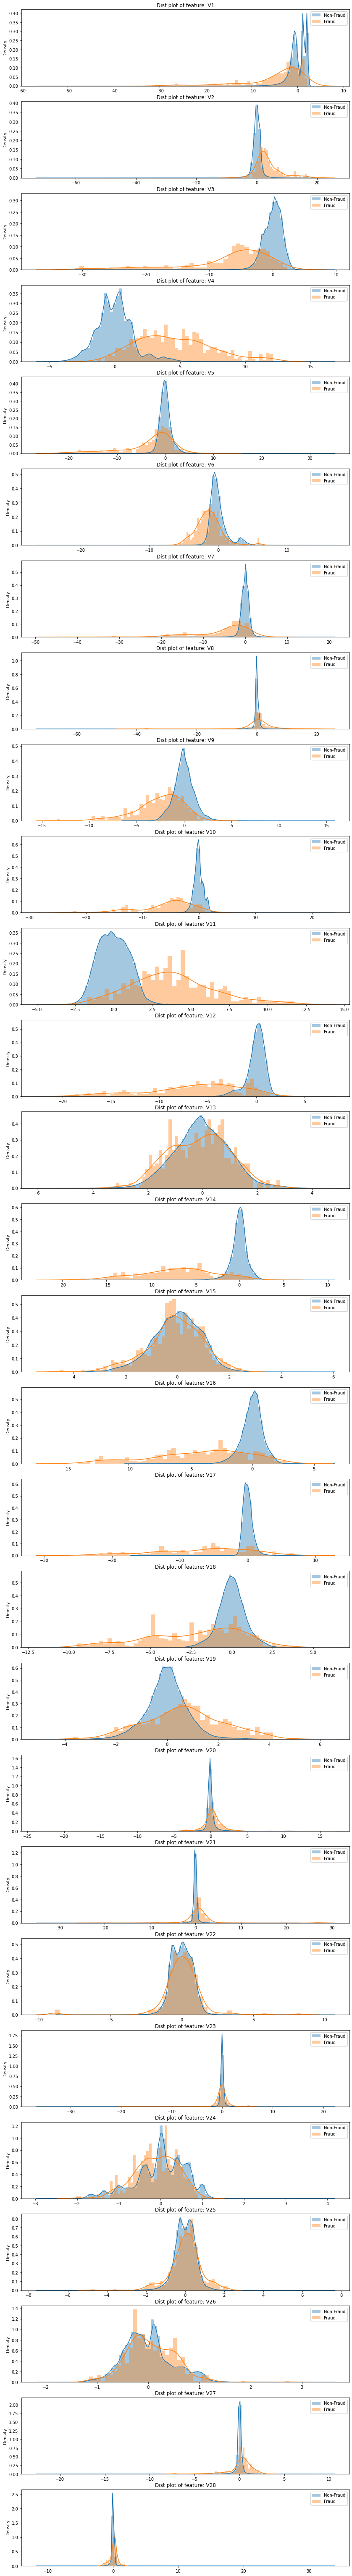

In [55]:
features_to_analyze = df.columns[1:29].tolist()
plt.figure(figsize=(14, 4*len(features_to_analyze)))
grid = gs.GridSpec(len(features_to_analyze), 1)
for index, value in enumerate(df[features_to_analyze]):
    # Distplot
    ax = plt.subplot(grid[index])
    sns.distplot(df[value][df.Fraud==0], bins=100, label='Non-Fraud')
    sns.distplot(df[value][df.Fraud==1], bins=50, label='Fraud')
    ax.set_xlabel('')
    ax.set_title("Dist plot of feature: {}".format(value))
    plt.legend()
plt.show()

# Split data into X and Y

In [56]:
df_hybrid_final_y = df_hybrid_merged['Fraud']
df_hybrid_final_x = df_hybrid_merged.drop(columns=['Fraud'], axis=1)

# Dropping features from train data set

In [57]:
columns_to_drop = ['V28','V27','V26','V25','V24','V23','V22','V20','V15','V13','V8']
df_hybrid_final_x = df_hybrid_final_x.drop(columns=columns_to_drop, axis=1)
df_hybrid_final_x.shape

(169806, 19)

# Dropping features from test data set

In [58]:
x_test = x_test.drop(columns=columns_to_drop, axis=1)
x_test.shape

(85356, 19)

# Logistic Regression Model (LR)

In [59]:
# import the class
from sklearn.linear_model import LogisticRegression
def predict_lr(x_train, y_train, x_test):
    logreg = LogisticRegression(max_iter=1000)
    # Fit / train
    logreg.fit(x_train, y_train)
    # Predict
    return logreg.predict(x_test)


lr_hybrid_predict = predict_lr(df_hybrid_final_x.values, 
                          df_hybrid_final_y.values, x_test.values)

#### Classification Precision / Recall / F1-Score for LR Model

In [60]:
ai_helper.print_metrics(y_test, lr_hybrid_predict)

Accuracy score: 0.9904400393645438
Precision score: 0.9983619075769729
Recall score: 0.9904400393645438
F1 score: 0.9938949271253764
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     85208
           1       0.14      0.91      0.25       148

    accuracy                           0.99     85356
   macro avg       0.57      0.95      0.62     85356
weighted avg       1.00      0.99      0.99     85356



#### Confusion matrix for LR Model

[[84405   803]
 [   13   135]]
Plotting confusion matrix


<Figure size 432x288 with 0 Axes>

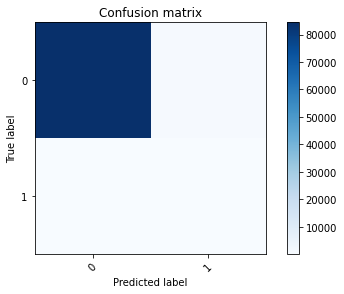

In [61]:
ai_helper.plot_cm(y_test.values, lr_hybrid_predict, [0,1])

#### ROC chart for LR Model


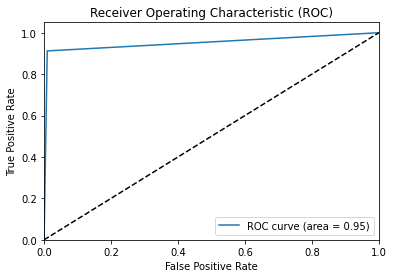

In [62]:
ai_helper.plot_roc(lr_hybrid_predict,y_test)

# Nearest Neighbour model (KNN) model

In [63]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=10)

# fit the model with data
knn.fit(df_hybrid_final_x.values,df_hybrid_final_y.values)

# predict the test data
knn_hybrid_predict = knn.predict(x_test.values)

#### Classification Precision / Recall / F1-Score for KNN Model


In [64]:
ai_helper.print_metrics(y_test, knn_hybrid_predict)

Accuracy score: 0.9979263320680444
Precision score: 0.9988471443297149
Recall score: 0.9979263320680444
F1 score: 0.9982631999327806
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85208
           1       0.45      0.89      0.60       148

    accuracy                           1.00     85356
   macro avg       0.72      0.94      0.80     85356
weighted avg       1.00      1.00      1.00     85356



#### Confusion matrix for KNN Model

[[85048   160]
 [   17   131]]
Plotting confusion matrix


<Figure size 432x288 with 0 Axes>

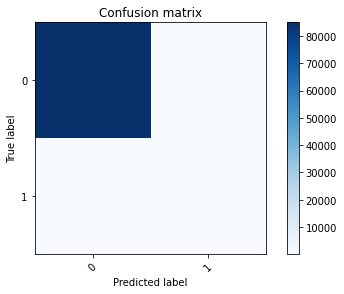

In [65]:
ai_helper.plot_cm(y_test.values, knn_hybrid_predict, [0,1])

#### ROC chart for for KNN Model

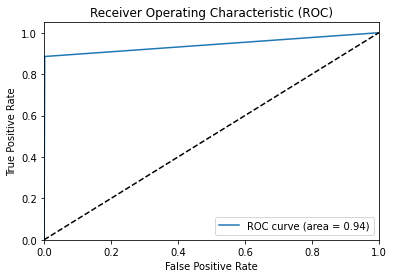

In [66]:
ai_helper.plot_roc(knn_hybrid_predict,y_test)

#Support vector machine model (SVM)

In [67]:
# Support vector machine model
from sklearn import svm
svm_model = svm.SVC()

# fit the model with data
svm_model.fit(df_hybrid_final_x.values,df_hybrid_final_y.values)

# predict the test data
svm_hybrid_predict = svm_model.predict(x_test.values)
svm_hybrid_predict

array([0, 0, 0, ..., 0, 0, 0])

#### Classification Precision / Recall / F1-Score for SVM Model

In [68]:
ai_helper.print_metrics(y_test, svm_hybrid_predict)

Accuracy score: 0.9970710904915882
Precision score: 0.9986642525758928
Recall score: 0.9970710904915882
F1 score: 0.9976804168284876
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85208
           1       0.36      0.87      0.51       148

    accuracy                           1.00     85356
   macro avg       0.68      0.93      0.75     85356
weighted avg       1.00      1.00      1.00     85356



#### Confusion matrix for SVM Model


[[84977   231]
 [   19   129]]
Plotting confusion matrix


<Figure size 432x288 with 0 Axes>

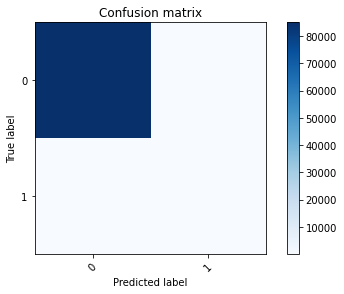

In [69]:
ai_helper.plot_cm(y_test.values, svm_hybrid_predict, [0,1])

#### ROC chart for SVM Model

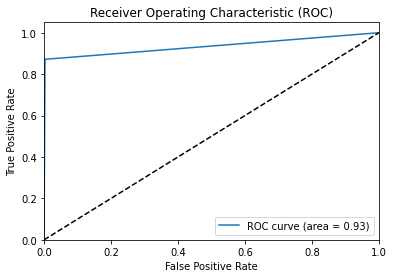

In [70]:
ai_helper.plot_roc(svm_hybrid_predict,y_test)

# Fully Connected Neural Network (NN) model

#### Preprocessing data set to NN acceptable format

In [71]:
y_train_nn = to_categorical(df_hybrid_final_y, 2)
y_test_nn = to_categorical(y_test, 2)

#### NN Model creation

In [72]:
checkpointer = ModelCheckpoint(filepath=os.path.join(dataset_path, 
                    "creditcard_data/dnn/nn_best_weights.hdf5"), 
                               verbose=0, save_best_only=True) # save best model

model = Sequential()

model.add(Dense(100, input_dim=df_hybrid_final_x.shape[1], activation='relu'))
model.add(Dense(75,activation='relu'))
model.add(Dense(50,activation='relu'))
model.add(Dense(30,activation='relu'))
model.add(Dense(20,activation='relu'))
model.add(Dense(15,activation='relu'))
model.add(Dense(y_train_nn.shape[1],activation='softmax')) 
# model.add(Dense(1,activation='sigmoid')) 
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               2000      
_________________________________________________________________
dense_1 (Dense)              (None, 75)                7575      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                3800      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1530      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                620       
_________________________________________________________________
dense_5 (Dense)              (None, 15)                315       
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 3

####Training the NN model

In [73]:
for i in range(5):
    print('Train... TRY {}'.format(i))
    model.compile(loss='categorical_crossentropy', optimizer='adam',
                  metrics=['accuracy'])
    # model.compile(loss='binary_crossentropy', optimizer='adam', 
    #               metrics=['accuracy'])
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, 
                            patience=3, verbose=2, mode='auto') 
    model.fit(df_hybrid_final_x.values, y_train_nn, 
              validation_data=(x_test.values,y_test_nn), 
              callbacks=[monitor, checkpointer], verbose=2, epochs=300) 

    # model.fit(df_hybrid_final_x.values, df_hybrid_final_y.values, 
    #           validation_data=(x_test.values, y_test.values), 
    #           callbacks=[monitor, checkpointer], verbose=2, epochs=300) 

Train... TRY 0
Epoch 1/300
5307/5307 - 18s - loss: 0.0291 - accuracy: 0.9904 - val_loss: 0.0096 - val_accuracy: 0.9977
Epoch 2/300
5307/5307 - 19s - loss: 0.0099 - accuracy: 0.9973 - val_loss: 0.0167 - val_accuracy: 0.9960
Epoch 3/300
5307/5307 - 19s - loss: 0.0076 - accuracy: 0.9980 - val_loss: 0.0102 - val_accuracy: 0.9980
Epoch 4/300
5307/5307 - 18s - loss: 0.0062 - accuracy: 0.9985 - val_loss: 0.0084 - val_accuracy: 0.9986
Epoch 5/300
5307/5307 - 18s - loss: 0.0058 - accuracy: 0.9985 - val_loss: 0.0105 - val_accuracy: 0.9971
Epoch 6/300
5307/5307 - 17s - loss: 0.0046 - accuracy: 0.9990 - val_loss: 0.0077 - val_accuracy: 0.9988
Epoch 7/300
5307/5307 - 18s - loss: 0.0042 - accuracy: 0.9990 - val_loss: 0.0055 - val_accuracy: 0.9992
Epoch 8/300
5307/5307 - 19s - loss: 0.0037 - accuracy: 0.9991 - val_loss: 0.0067 - val_accuracy: 0.9992
Epoch 9/300
5307/5307 - 18s - loss: 0.0038 - accuracy: 0.9992 - val_loss: 0.0070 - val_accuracy: 0.9993
Epoch 10/300
5307/5307 - 18s - loss: 0.0036 - acc

#### Run the prediction

In [74]:
model.load_weights(os.path.join(dataset_path, 
                    "creditcard_data/dnn/nn_best_weights.hdf5")) # load weights from best model
pred = model.predict(x_test.values)
print(pred[0:5]) # print first five predictions
pred = np.argmax(pred,axis=1)

[[1.0000000e+00 1.2090094e-13]
 [1.0000000e+00 1.8797509e-12]
 [1.0000000e+00 7.1775891e-13]
 [1.0000000e+00 2.1814498e-14]
 [9.9990034e-01 9.9692756e-05]]


#### Classification Precision / Recall / F1-Score for NN Model


In [75]:
ai_helper.print_metrics(y_test, pred)

Accuracy score: 0.9991916209756784
Precision score: 0.9993004752877844
Recall score: 0.9991916209756784
F1 score: 0.9992320844969015
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85208
           1       0.72      0.88      0.79       148

    accuracy                           1.00     85356
   macro avg       0.86      0.94      0.89     85356
weighted avg       1.00      1.00      1.00     85356



#### Confusion matrix for NN Model


[[85157    51]
 [   18   130]]
Plotting confusion matrix


<Figure size 432x288 with 0 Axes>

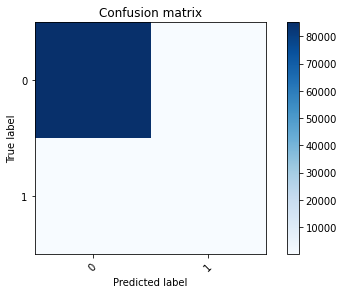

In [76]:
ai_helper.plot_cm(y_test.values, pred, [0,1])

#### ROC curve for NN Model


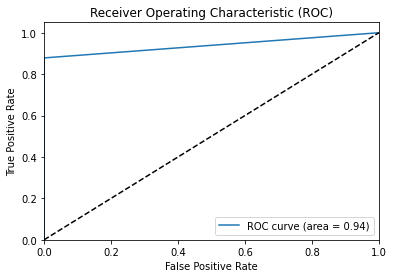

In [77]:
ai_helper.plot_roc(pred, y_test)

#LSTM model

#### Prepocessing data set to LSTM acceptable format

In [78]:
x_train_lstm = df_hybrid_final_x.values.reshape(df_hybrid_final_x.shape[0],df_hybrid_final_x.shape[1],1)
y_train_lstm = to_categorical(df_hybrid_final_y, 2)

x_test_lstm = x_test.values.reshape(x_test.shape[0],x_test.shape[1],1)
y_test_lstm = to_categorical(y_test, 2)

print('Shape \tx_train={}\ty_train={}\nShape \tx_test={}\ty_test={}'.format(
        x_train_lstm.shape, y_train_lstm.shape, x_test_lstm.shape, y_test_lstm.shape))

Shape 	x_train=(169806, 19, 1)	y_train=(169806, 2)
Shape 	x_test=(85356, 19, 1)	y_test=(85356, 2)


#### LSTM model creation

In [79]:
checkpointer = ModelCheckpoint(filepath=os.path.join(dataset_path, 
                    "creditcard_data/dnn/best_weights_finalProject_lstm.hdf5" ),
                               verbose=0, save_best_only=True) # save best model

# lstm_model = Sequential()

# lstm_model.add(LSTM(64, activation='relu', dropout=0.2, recurrent_dropout=0.2, 
#                input_shape=(x_train_lstm.shape[1], x_train_lstm.shape[2])))
# lstm_model.add(Dense(32, activation='relu'))
# lstm_model.add(Dense(16, activation='relu'))
# lstm_model.add(Dense(2, activation='softmax'))


lstm_model = Sequential()
lstm_model.add(LSTM(128, return_sequences=False, input_shape=(x_train_lstm.shape[1], x_train_lstm.shape[2])))
lstm_model.add(Dense(64, activation='relu'))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(2, activation='softmax'))
lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               66560     
_________________________________________________________________
dense_7 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 2)                 130       
Total params: 74,946
Trainable params: 74,946
Non-trainable params: 0
_________________________________________________________________


#### Training the LSTM model

In [80]:
for i in range(3):
    print('Train... TRY {}'.format(i))
    lstm_model.compile(loss='categorical_crossentropy',
              optimizer='adam',metrics=['accuracy'])
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=5, 
                            verbose=1, mode='auto')

    lstm_model.fit(x_train_lstm, y_train_lstm ,validation_data=(x_test_lstm, y_test_lstm),
                   callbacks=[monitor],verbose=2, epochs=100)
    
    

Train... TRY 0
Epoch 1/100
5307/5307 - 26s - loss: 0.0917 - accuracy: 0.9710 - val_loss: 0.0228 - val_accuracy: 0.9903
Epoch 2/100
5307/5307 - 26s - loss: 0.0208 - accuracy: 0.9928 - val_loss: 0.0147 - val_accuracy: 0.9957
Epoch 3/100
5307/5307 - 26s - loss: 0.0132 - accuracy: 0.9960 - val_loss: 0.0108 - val_accuracy: 0.9971
Epoch 4/100
5307/5307 - 25s - loss: 0.0095 - accuracy: 0.9973 - val_loss: 0.0120 - val_accuracy: 0.9968
Epoch 5/100
5307/5307 - 25s - loss: 0.0079 - accuracy: 0.9978 - val_loss: 0.0098 - val_accuracy: 0.9980
Epoch 6/100
5307/5307 - 25s - loss: 0.0069 - accuracy: 0.9982 - val_loss: 0.0105 - val_accuracy: 0.9977
Epoch 7/100
5307/5307 - 26s - loss: 0.0060 - accuracy: 0.9985 - val_loss: 0.0068 - val_accuracy: 0.9987
Epoch 8/100
5307/5307 - 24s - loss: 0.0052 - accuracy: 0.9987 - val_loss: 0.0065 - val_accuracy: 0.9988
Epoch 9/100
5307/5307 - 25s - loss: 0.0046 - accuracy: 0.9989 - val_loss: 0.0068 - val_accuracy: 0.9989
Epoch 10/100
5307/5307 - 25s - loss: 0.0043 - acc

#### Run the prediction

In [84]:
#lstm_model.load_weights('dnn/best_weights_finalProject_lstm.hdf5') # load weights from best model
pred_lstm = lstm_model.predict(x_test_lstm)
print(pred_lstm)
pred_lstm = np.argmax(pred_lstm,axis=1)
y_true_lstm= np.argmax(y_test_lstm,axis=1) 

[[9.9995124e-01 4.8702870e-05]
 [9.9998248e-01 1.7564897e-05]
 [9.9930131e-01 6.9868966e-04]
 ...
 [9.9749529e-01 2.5047183e-03]
 [9.9999976e-01 2.3562625e-07]
 [9.9999142e-01 8.6104847e-06]]


#### Classification Precision / Recall / F1-Score for LSTM Model

In [85]:
print(metrics.classification_report(y_true_lstm, pred_lstm))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85208
           1       0.62      0.87      0.72       148

    accuracy                           1.00     85356
   macro avg       0.81      0.94      0.86     85356
weighted avg       1.00      1.00      1.00     85356



#### Confusion matrix for LSTM model


[[85128    80]
 [   19   129]]
Plotting confusion matrix


<Figure size 432x288 with 0 Axes>

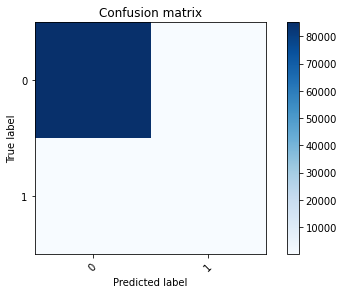

In [86]:
ai_helper.plot_cm(y_test.values, pred_lstm, [0,1])

#### ROC curve for LSTM model

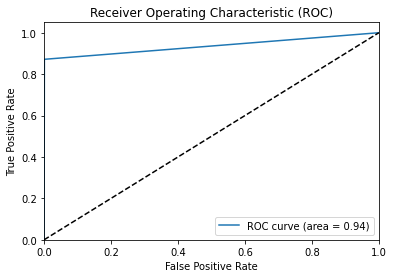

In [87]:
ai_helper.plot_roc(pred_lstm,y_test)

# Convolution neural network (CNN) - 2D Model

#### Prepocessing data set to CNN 2D acceptable format

In [88]:
x_train_cnn = df_hybrid_final_x.values.reshape(df_hybrid_final_x.shape[0],1,df_hybrid_final_x.shape[1],1)
y_train_cnn = to_categorical(df_hybrid_final_y, 2)

x_test_cnn = x_test.values.reshape(x_test.shape[0],1,x_test.shape[1],1)
y_test_cnn = to_categorical(y_test, 2)

print("x_train_cnn: {}".format(x_train_cnn.shape))
print("x_test_cnn: {}\n".format(x_test_cnn.shape))

print("y_train_cnn: {}".format(y_train_cnn.shape))
print("y_test_cnn: {}\n".format(y_test_cnn.shape))

x_train_cnn: (169806, 1, 19, 1)
x_test_cnn: (85356, 1, 19, 1)

y_train_cnn: (169806, 2)
y_test_cnn: (85356, 2)



#### CNN 2D model creation

In [89]:
# define a CNN

cnn = Sequential()
cnn.add(Conv2D(64, kernel_size=(1, 3), strides=(1, 1),
                 activation='relu',
                 input_shape=(x_train_cnn.shape[1], x_train_cnn.shape[2], x_train_cnn.shape[3])))

cnn.add(MaxPooling2D(pool_size=(1,2)))

cnn.add(Conv2D(128, kernel_size=(1, 3), strides=(1, 1),
                 activation='relu'))
cnn.add(MaxPooling2D(pool_size=(1,2)))
    
    
cnn.add(Flatten())
cnn.add(Dense(1024, activation="relu"))
cnn.add(Dropout(0.5))
cnn.add(Dense(2, activation="softmax"))

cnn.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 1, 17, 64)         256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 1, 8, 64)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 1, 6, 128)         24704     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 1, 3, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 384)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 1024)              394240    
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)             

#### Training the CNN 2D model 

In [90]:
checkpointer = ModelCheckpoint(filepath=os.path.join(dataset_path, 
                    "creditcard_data/dnn/cnn_best_weights.hdf5"), 
                               verbose=0, save_best_only=True) # save best model
for i in range(5):
    cnn.compile(loss="categorical_crossentropy", optimizer="adam",
                metrics=['accuracy'])
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=5, 
                            verbose=1, mode='auto')
    cnn.fit(x_train_cnn, y_train_cnn, validation_data=(x_test_cnn, y_test_cnn),
              callbacks=[monitor, checkpointer], verbose=2, epochs=300)

Epoch 1/300
5307/5307 - 19s - loss: 0.0387 - accuracy: 0.9864 - val_loss: 0.0181 - val_accuracy: 0.9961
Epoch 2/300
5307/5307 - 19s - loss: 0.0136 - accuracy: 0.9961 - val_loss: 0.0166 - val_accuracy: 0.9963
Epoch 3/300
5307/5307 - 18s - loss: 0.0105 - accuracy: 0.9971 - val_loss: 0.0156 - val_accuracy: 0.9970
Epoch 4/300
5307/5307 - 18s - loss: 0.0092 - accuracy: 0.9976 - val_loss: 0.0130 - val_accuracy: 0.9978
Epoch 5/300
5307/5307 - 18s - loss: 0.0082 - accuracy: 0.9980 - val_loss: 0.0160 - val_accuracy: 0.9976
Epoch 6/300
5307/5307 - 19s - loss: 0.0083 - accuracy: 0.9983 - val_loss: 0.0134 - val_accuracy: 0.9979
Epoch 7/300
5307/5307 - 19s - loss: 0.0067 - accuracy: 0.9985 - val_loss: 0.0113 - val_accuracy: 0.9989
Epoch 8/300
5307/5307 - 19s - loss: 0.0060 - accuracy: 0.9987 - val_loss: 0.0169 - val_accuracy: 0.9986
Epoch 9/300
5307/5307 - 18s - loss: 0.0060 - accuracy: 0.9987 - val_loss: 0.0162 - val_accuracy: 0.9976
Epoch 10/300
5307/5307 - 18s - loss: 0.0060 - accuracy: 0.9988 -

#### Run the prediction

In [91]:
cnn.load_weights(os.path.join(dataset_path, 
                    "creditcard_data/dnn/cnn_best_weights.hdf5")) # load weights from best model
pred_cnn = cnn.predict(x_test_cnn)
y_true= np.argmax(y_test_cnn,axis=1) 
pred_cnn = np.argmax(pred_cnn,axis=1)

#### Classification Precision / Recall / F1-Score for CNN 2D Model

In [92]:
print(metrics.classification_report(y_true, pred_cnn))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85208
           1       0.63      0.86      0.73       148

    accuracy                           1.00     85356
   macro avg       0.82      0.93      0.86     85356
weighted avg       1.00      1.00      1.00     85356



####Confusion matrix for CNN-2D model


[[85134    74]
 [   21   127]]
Plotting confusion matrix


<Figure size 432x288 with 0 Axes>

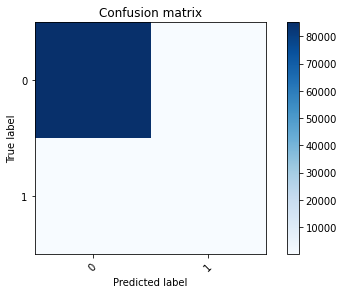

In [93]:
ai_helper.plot_cm(y_test.values, pred_cnn, [0,1])

#### ROC curve for CNN-2D model

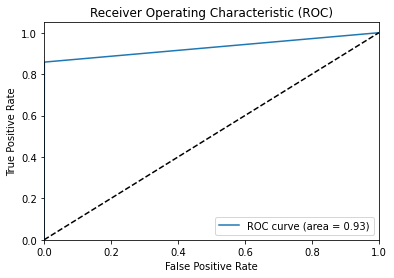

In [94]:
ai_helper.plot_roc(pred_cnn,y_test)

# Convolution neural network (CNN) - 1D

#### Prepocessing data set to CNN 1D acceptable format

In [97]:
x_train_cnn_1D = df_hybrid_final_x.values.reshape(df_hybrid_final_x.shape[0],df_hybrid_final_x.shape[1],1)
y_train_cnn_1D = to_categorical(df_hybrid_final_y, 2)

x_test_cnn_1D = x_test.values.reshape(x_test.shape[0],x_test.shape[1],1)
y_test_cnn_1D = to_categorical(y_test, 2)

print("x_train_cnn: {}".format(x_train_cnn_1D.shape))
print("x_test_cnn: {}\n".format(x_test_cnn_1D.shape))


print("y_train_cnn: {}".format(y_train_cnn_1D.shape))
print("y_test_cnn: {}\n".format(y_test_cnn_1D.shape))

x_train_cnn: (169806, 19, 1)
x_test_cnn: (85356, 19, 1)

y_train_cnn: (169806, 2)
y_test_cnn: (85356, 2)



#### CNN 1D model creation

In [98]:
cnn_1D = Sequential()

cnn_1D.add(Conv1D(64, kernel_size=3, strides=1 ,activation='relu',
                 input_shape=(x_train_cnn_1D.shape[1], x_train_cnn_1D.shape[2])))
cnn_1D.add(MaxPooling1D(pool_size=1))


cnn_1D.add(Conv1D(128, kernel_size=3, strides=1,
                 activation='relu'))
cnn_1D.add(MaxPooling1D(pool_size=1))
    
    
cnn_1D.add(Flatten())
cnn_1D.add(Dense(1024, activation="relu"))
cnn_1D.add(Dropout(0.5))
cnn_1D.add(Dense(2, activation="softmax"))
cnn_1D.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 17, 64)            256       
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 17, 64)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 15, 128)           24704     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 15, 128)           0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1920)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 1024)              1967104   
_________________________________________________________________
dropout_3 (Dropout)          (None, 1024)             

#### Training the CNN 1D Model

In [100]:
checkpointer = ModelCheckpoint(filepath=os.path.join(dataset_path, 
                    "creditcard_data/dnn/cnn1D_best_weights.hdf5"), 
                               verbose=0, save_best_only=True) # save best model
for i in range(5):
    print('Train... TRY {}'.format(i))
    cnn_1D.compile(loss="binary_crossentropy", optimizer="adam",
                   metrics="accuracy")
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=5, 
                            verbose=1, mode='auto')
    cnn_1D.fit(x_train_cnn_1D, y_train_cnn_1D, validation_data=(x_test_cnn_1D, y_test_cnn_1D),
              callbacks=[monitor, checkpointer], verbose=2, epochs=300)

Train... TRY 0
Epoch 1/300
5307/5307 - 22s - loss: 0.0152 - accuracy: 0.9955 - val_loss: 0.0130 - val_accuracy: 0.9974
Epoch 2/300
5307/5307 - 24s - loss: 0.0106 - accuracy: 0.9973 - val_loss: 0.0110 - val_accuracy: 0.9979
Epoch 3/300
5307/5307 - 22s - loss: 0.0086 - accuracy: 0.9981 - val_loss: 0.0116 - val_accuracy: 0.9979
Epoch 4/300
5307/5307 - 22s - loss: 0.0075 - accuracy: 0.9984 - val_loss: 0.0105 - val_accuracy: 0.9985
Epoch 5/300
5307/5307 - 22s - loss: 0.0071 - accuracy: 0.9986 - val_loss: 0.0095 - val_accuracy: 0.9987
Epoch 6/300
5307/5307 - 21s - loss: 0.0075 - accuracy: 0.9985 - val_loss: 0.0105 - val_accuracy: 0.9987
Epoch 7/300
5307/5307 - 21s - loss: 0.0063 - accuracy: 0.9988 - val_loss: 0.0100 - val_accuracy: 0.9985
Epoch 8/300
5307/5307 - 22s - loss: 0.0053 - accuracy: 0.9991 - val_loss: 0.0089 - val_accuracy: 0.9991
Epoch 9/300
5307/5307 - 21s - loss: 0.0063 - accuracy: 0.9990 - val_loss: 0.0107 - val_accuracy: 0.9987
Epoch 10/300
5307/5307 - 22s - loss: 0.0050 - acc

#### Run the prediction

In [101]:
cnn_1D.load_weights(os.path.join(dataset_path, 
                    "creditcard_data/dnn/cnn1D_best_weights.hdf5")) # load weights from best model
pred_cnn_1D = cnn_1D.predict(x_test_cnn_1D)
pred_cnn_1D = np.argmax(pred_cnn_1D,axis=1)
y_true_1D= np.argmax(y_test_cnn_1D,axis=1) 

#### Classification Precision / Recall / F1-Score for CNN 1D Model

In [102]:
print(metrics.classification_report(y_true_1D, pred_cnn_1D))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85208
           1       0.69      0.87      0.77       148

    accuracy                           1.00     85356
   macro avg       0.85      0.94      0.89     85356
weighted avg       1.00      1.00      1.00     85356



####Confusion matrix for CNN-1D model


[[85151    57]
 [   19   129]]
Plotting confusion matrix


<Figure size 432x288 with 0 Axes>

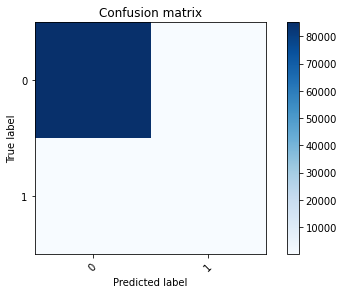

In [103]:
ai_helper.plot_cm(y_test.values, pred_cnn_1D, [0,1])

#### ROC curve for CNN-1D model

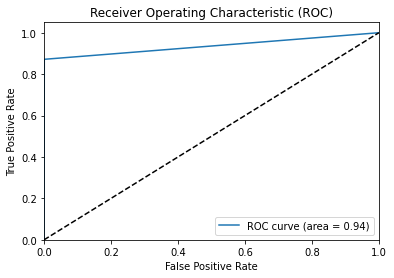

In [104]:
ai_helper.plot_roc(pred_cnn_1D,y_test)